In [5]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt

In [6]:
gym.register_envs(ale_py)
env = gym.make("ALE/Pong-v5", frameskip=5, render_mode="rgb_array")

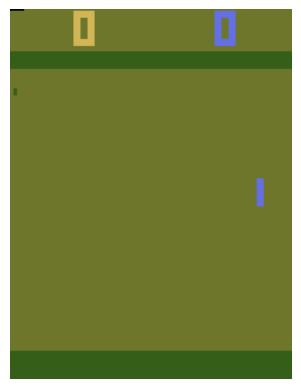

In [7]:
frame = env.reset()
img = env.render()  # returns an RGB array
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
from stable_baselines3 import DQN

In [9]:
#!pip install "gymnasium[other]"

In [10]:
import cv2
import numpy as np
def preprocess_frame(screen, exclude, output):
    """Preprocess Image.
        Params
        ======
            screen (array): RGB Image
            exclude (tuple): Section to be croped (UP, RIGHT, DOWN, LEFT)
            output (int): Size of output image
        """
    # TConver image to gray scale
    screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)

    #Crop screen[Up: Down, Left: right]
    #screen = screen[exclude[0]:exclude[2], exclude[3]:exclude[1]]

    # Convert to float, and normalized
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255

    # Resize image to output * output
    screen = cv2.resize(screen, (output, output), interpolation = cv2.INTER_AREA)
    return screen

In [11]:
INPUT_SHAPE = (4, 84, 84)
def stack_frame(stacked_frames, frame, is_new):
    """Stacking Frames.
        Params
        ======
            stacked_frames (array): Four Channel Stacked Frame
            frame: Preprocessed Frame to be added
            is_new: Is the state First
        """
    if is_new:
        stacked_frames = np.stack(arrays=[frame, frame, frame, frame])
        stacked_frames = stacked_frames
    else:
        stacked_frames[0] = stacked_frames[1]
        stacked_frames[1] = stacked_frames[2]
        stacked_frames[2] = stacked_frames[3]
        stacked_frames[3] = frame

    return stacked_frames

def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), INPUT_SHAPE[1])
    frames = stack_frame(frames, frame, is_new)

    return frames

In [12]:
import numpy as np

class AtariPreprocessingWrapper(gym.Wrapper):
    def __init__(self, env, input_shape=(4, 84, 84)):
        super(AtariPreprocessingWrapper, self).__init__(env)
        self.input_shape = input_shape
        self.stacked_frames = np.zeros(self.input_shape, dtype=np.float32)
        # Update the observation_space to match the preprocessed output
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=self.input_shape, dtype=np.float32
        )

    def preprocess_frame(self, screen, exclude, output):
        screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.0
        screen = cv2.resize(screen, (output, output), interpolation=cv2.INTER_AREA)
        return screen

    def stack_frame(self, stacked_frames, frame, is_new):
        if is_new:
            stacked_frames = np.stack([frame] * 4, axis=0)
        else:
            stacked_frames[:-1] = stacked_frames[1:]
            stacked_frames[-1] = frame
        return stacked_frames

    def reset(self):
        state, _ = self.env.reset()  # Unpack the (obs, info) tuple
        frame = self.preprocess_frame(state, (8, -12, -12, 4), self.input_shape[1])
        self.stacked_frames = self.stack_frame(self.stacked_frames, frame, is_new=True)
        return self.stacked_frames


    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated

        frame = self.preprocess_frame(next_state, (8, -12, -12, 4), self.input_shape[1])
        self.stacked_frames = self.stack_frame(self.stacked_frames, frame, is_new=False)

        return self.stacked_frames, reward, done, info



In [13]:
env_ = AtariPreprocessingWrapper(env)

In [14]:
print(env_.observation_space)

Box(0.0, 1.0, (4, 84, 84), float32)


In [15]:
# After resetting the environment
obs = env_.reset()
print("Shape:", obs.shape)        # Should be (4, 84, 84)
print("Dtype:", obs.dtype)        # Should be float32
print("Min/Max:", obs.min(), obs.max())  # Should be between 0.0 and 1.0

Shape: (4, 84, 84)
Dtype: float32
Min/Max: 0.2517647 0.7019608


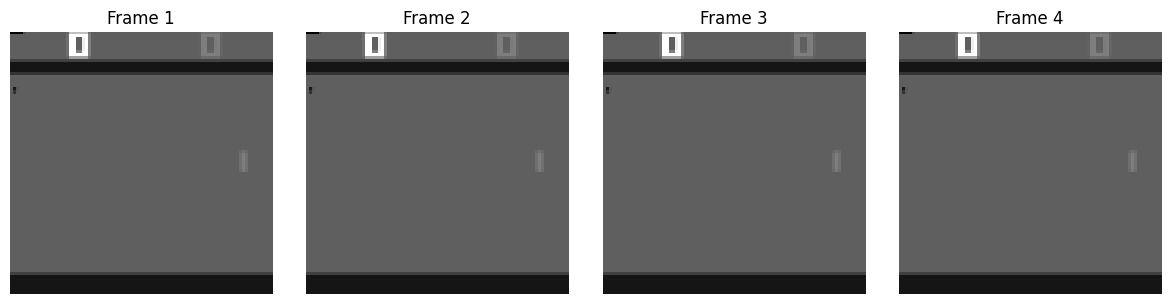

In [16]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(obs[i], cmap='gray')
    axs[i].set_title(f'Frame {i+1}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [15]:
model = DQN("CnnPolicy", env, verbose=1, seed=42)

timestamps = 10_000

model.learn(total_timesteps=timestamps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/opt/anaconda3/envs/shhh/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 201.62GB > 1.32GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 668      |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 11       |
|    time_elapsed     | 227      |
|    total_timesteps  | 2670     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0005   |
|    n_updates        | 642      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 661      |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 12       |
|    time_elapsed     | 416      |
|    total_timesteps  | 5286     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0149   |
|    n_updates      

In [16]:
from utils import run_episodes

In [ ]:
evaluate_agent(model, env, num_episodes=10, render=True)

In [17]:
episodes = 500

rewards_dqn = run_episodes(model, env, n_episodes=episodes)

Episode 1: Reward = -21.00
Episode 2: Reward = -21.00
Episode 3: Reward = -21.00
Episode 4: Reward = -21.00
Episode 5: Reward = -21.00
Episode 6: Reward = -21.00
Episode 7: Reward = -21.00
Episode 8: Reward = -21.00
Episode 9: Reward = -21.00
Episode 10: Reward = -21.00
Episode 11: Reward = -21.00
Episode 12: Reward = -21.00
Episode 13: Reward = -21.00
Episode 14: Reward = -21.00
Episode 15: Reward = -21.00
Episode 16: Reward = -21.00
Episode 17: Reward = -21.00
Episode 18: Reward = -21.00
Episode 19: Reward = -21.00
Episode 20: Reward = -21.00
Episode 21: Reward = -21.00
Episode 22: Reward = -21.00
Episode 23: Reward = -21.00
Episode 24: Reward = -21.00
Episode 25: Reward = -21.00
Episode 26: Reward = -21.00
Episode 27: Reward = -21.00
Episode 28: Reward = -21.00
Episode 29: Reward = -21.00
Episode 30: Reward = -21.00
Episode 31: Reward = -21.00
Episode 32: Reward = -21.00
Episode 33: Reward = -21.00
Episode 34: Reward = -21.00
Episode 35: Reward = -21.00
Episode 36: Reward = -21.00
E

In [18]:
import matplotlib.pyplot as plt

def plot_rewards(reward_list, title, save_path=None):
    plt.figure(figsize=(10, 5))
    plt.plot(reward_list, label='Reward per Episode')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.grid()
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

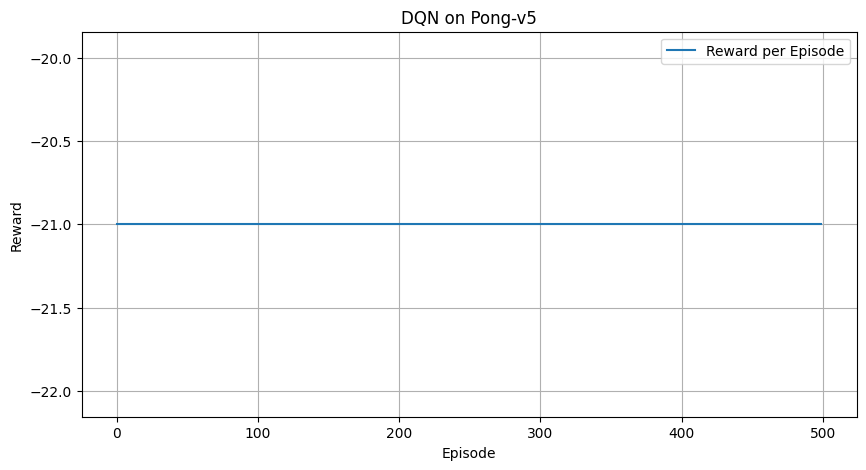

In [19]:
plot_rewards(rewards_dqn, "DQN on Pong-v5")

In [20]:
from stable_baselines3 import PPO

# Initialize model
model_PPO = PPO("CnnPolicy", env, verbose=1)

# Train
model_PPO.learn(total_timesteps=20_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 835      |
|    ep_rew_mean     | -19.5    |
| time/              |          |
|    fps             | 185      |
|    iterations      | 1        |
|    time_elapsed    | 11       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 775         |
|    ep_rew_mean          | -20.4       |
| time/                   |             |
|    fps                  | 36          |
|    iterations           | 2           |
|    time_elapsed         | 111         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011270843 |
|    clip_fraction        | 0.133       |
|    clip_range      

In [23]:
# Evaluate
episode_rewards = []

for _ in range(500):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model_PPO.predict(obs)
        obs, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        total_reward += reward  # for VecEnv
    episode_rewards.append(total_reward)

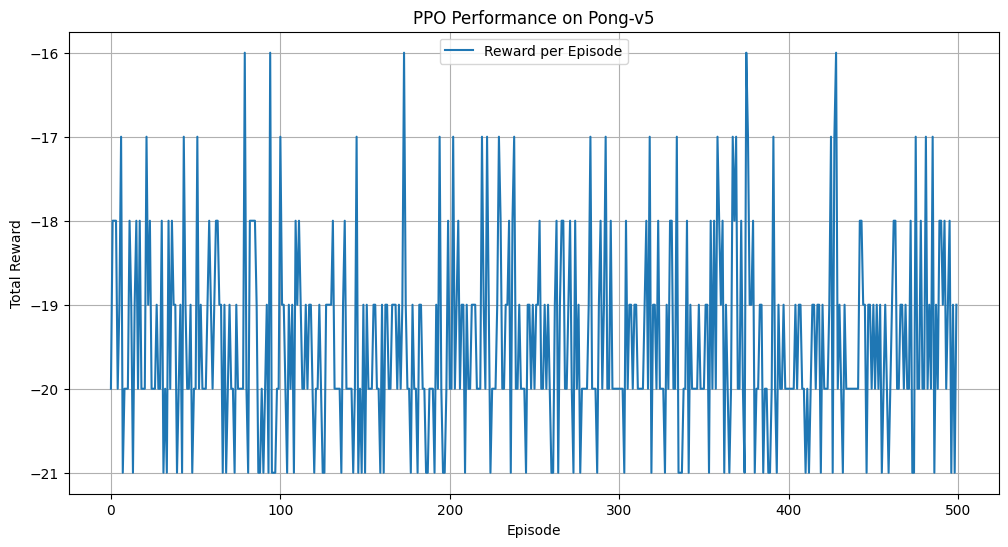

In [24]:
import matplotlib.pyplot as plt

# Plotting reward per episode
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PPO Performance on Pong-v5')
plt.grid()
plt.legend()
plt.show()

In [20]:
from sb3_contrib import QRDQN

model_qrdqn = QRDQN("CnnPolicy", env, verbose=1)
model_qrdqn.learn(total_timesteps=30_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/opt/anaconda3/envs/shhh/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 201.62GB > 1.54GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 633      |
|    ep_rew_mean      | -21      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 13       |
|    time_elapsed     | 186      |
|    total_timesteps  | 2532     |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 0.168    |
|    n_updates        | 607      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 622      |
|    ep_rew_mean      | -21      |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 14       |
|    time_elapsed     | 340      |
|    total_timesteps  | 4980     |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 2.67     |
|    n_updates      

In [21]:
episode_rewards_qrdqn = []

for _ in range(300):  
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model_qrdqn.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        total_reward += reward

    episode_rewards_qrdqn.append(total_reward)


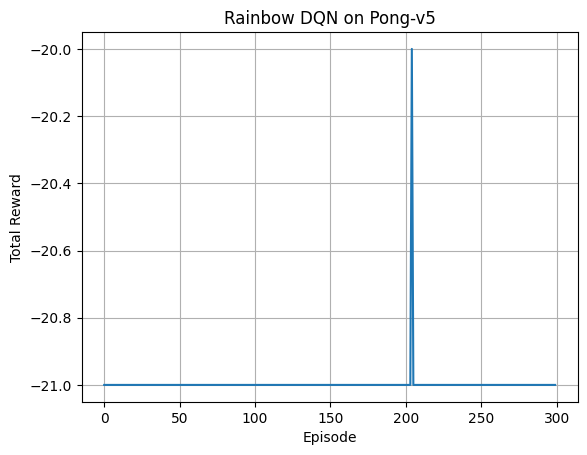

In [22]:
plt.plot(episode_rewards_qrdqn)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rainbow DQN on Pong-v5")
plt.grid()
plt.show()

In [23]:
from stable_baselines3 import A2C

model_a2c = A2C(
    "CnnPolicy",
    env,
    verbose=1,
    learning_rate=7e-4,
    n_steps=5,
    gamma=0.99,
    gae_lambda=1.0,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    use_rms_prop=True,
    rms_prop_eps=1e-5
)

model_a2c.learn(total_timesteps=100_000)  # Increase for better performance

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
------------------------------------
| time/                 |          |
|    fps                | 68       |
|    iterations         | 100      |
|    time_elapsed       | 7        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.79    |
|    explained_variance | -1.04    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0287   |
|    value_loss         | 0.00035  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 719      |
|    ep_rew_mean        | -21      |
| time/                 |          |
|    fps                | 66       |
|    iterations         | 200      |
|    time_elapsed       | 15       |
|    total_timesteps    | 1000     |
| train/      

In [24]:
episode_rewards_a2c = []

for _ in range(350):  # Adjust for more evaluation episodes
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model_a2c.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        total_reward += reward

    episode_rewards_a2c.append(total_reward)

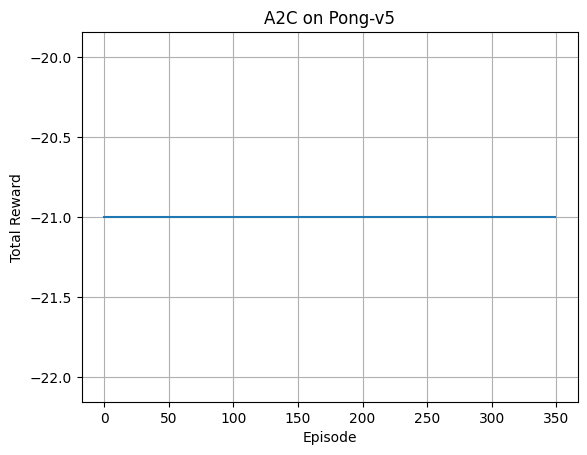

In [25]:
plt.plot(episode_rewards_a2c)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("A2C on Pong-v5")
plt.grid()
plt.show()

### OLD CODE

In [ ]:
from stable_baselines3 import DQN

# Create and train the agent
model = DQN("CnnPolicy", env, verbose=1, tensorboard_log="./pong_dqn_log/")
model.learn(total_timesteps=1000)  

# Evaluate and record a video
obs, _ = env.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()
print(f"Video saved to: {video_folder}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/opt/anaconda3/envs/shhh/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 201.62GB > 1.28GB
  warnings.warn(


Logging to ./pong_dqn_log/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 678      |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.742    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 13       |
|    time_elapsed     | 194      |
|    total_timesteps  | 2714     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0153   |
|    n_updates        | 653      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 671      |
|    ep_rew_mean      | -20.6    |
|    exploration_rate | 0.49     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 12       |
|    time_elapsed     | 416      |
|    total_timesteps  | 5370     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             |

python(68262) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(68263) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


KeyboardInterrupt: 